# **REINFORCEMENT LEARNING PROJECT - DQN AGENT**

In [ ]:
## INSTALLATIONS.
!sudo apt update
!sudo apt install -y build-essential autoconf libtool pkg-config python3-dev \
    python3-pip python3-numpy git flex bison libbz2-dev

!wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add -
!sudo apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main'
!sudo apt-get update && apt-get --allow-unauthenticated install -y \
    cmake \
    kitware-archive-keyring

# feel free to use a more elegant solution to make /usr/bin/cmake the default one
!sudo rm $(which cmake)
!$(which cmake) --version

# install nle and minihack
!pip install nle
!pip install minihack

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,230 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:14 http://ppa.launch

In [ ]:
## LIBRARIES
import os
import gym
import math
import torch
import random
import imageio
import minihack
import numpy as np
from model import DQN
from gym import spaces
from nle import nethack
from agent import DQNAgent
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.display import Image
from minihack import RewardManager
from replay_buffer import ReplayBuffer

Code was adapted from [Here](https://github.com/raillab/dqn) and modified to fit our requirements.

In [ ]:
# 1. Mount google drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 2. Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1. HELPER FUNCTIONS**

In [ ]:
def display_image(state):
  """Displays the image of state['pixel']."""
  img = np.uint8(state['pixel'])
  plt.figure(figsize=(15, 7))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
def moving_average(arr, n):
  """Calculates the moving average of an array arr, with a window size n"""
  cummulative_sum = np.cumsum(arr, dtype=float)
  cummulative_sum[n:] = cummulative_sum[n:] - cummulative_sum[:-n]
  return cummulative_sum / n

In [ ]:
def format_state(state):
  """Formats the state into form that the CNN can accept"""
  glyphs = state["glyphs"]
  glyphs = glyphs / glyphs.max() # Standardize the glyphs
  glyphs = glyphs.reshape((1, 1, 21, 79)) # reshape
  return torch.from_numpy(glyphs).squeeze(0)

In [ ]:
def plot_results(scores):
  """
  Plots the reward acquired by an agent at each step of training in 
  an environment for each iteration and average over all iterations
  """
  
  plt.figure(figsize=(8, 6))
  
  # Plot the scores 
  for score in scores:
      plt.plot(score, color='blue', label='Learning curve')
  
  plt.title("DQN - Learning curve")
  plt.xlabel("Episode Number")
  plt.ylabel("Reward")
  plt.legend()
  plt.savefig('DQN-learning curve')
  plt.show()

## **2. TRAIN DQN AGENT**

In [ ]:
def train_dqn_agent(env, seed):
  """
  Method to train DQN model.
  
  Input:
  env: The environment to be used during training
  seed: The random seed for any random operations performed
  
  Returns:
  scores: The cumulative reward achieved by the agent for each episode during traiing
  """

  hyper_params = {
      'replay-buffer-size': int(1e6),
      'learning-rate': 0.01,
      'gamma': 0.99,  # discount factor
      'num-steps': int(5e5),  # Steps to run for, max episodes should be hit before this
      'batch-size': 32,
      'learning-starts': 1000,  # set learning to start after 1000 steps of exploration
      'learning-freq': 1,  # Optimize after each step
      'use-double-dqn': True,
      'target-update-freq': 1000, # number of iterations between every target network update
      'eps-start': 1.0,  # e-greedy start threshold 
      'eps-end': 0.1,  # e-greedy end threshold 
      'eps-fraction': 0.4,  # Percentage of the time that epsilon is annealed
      'print-freq': 1,
  }
  
  np.random.seed(seed)
  env.seed(seed)
  
  # Create DQN agent
  replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
  agent = DQNAgent(
      env.observation_space, 
      env.action_space,
      train=True,
      replay_buffer=replay_buffer,
      use_double_dqn=hyper_params['use-double-dqn'],
      lr=hyper_params['learning-rate'],
      batch_size=hyper_params['batch-size'],
      gamma=hyper_params['gamma'],
  )
  
  # define variables to track agent metrics
  total_reward = 0
  scores = []
  mean_rewards = []

  # Reset gym env before training
  state = format_state(env.reset())
  eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])

  # Train for set number of steps
  for t in range(hyper_params['num-steps']):

    # determine exploration probability
    fract = min(1.0, float(t) / eps_timesteps)
    eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
    sample = random.random()
    
    # Decide to explore and choose random action or use model to act
    if sample < eps_threshold:
      action = np.random.choice(agent.action_space.n)
    else:
      action = agent.act(state)
    
    # Take step in environment
    (next_state, reward, done, _) = env.step(action)
    next_state = format_state(next_state)
    replay_buffer.add(state, action, reward, next_state, float(done))
    total_reward += reward
    state = next_state

    if done:
      scores.append(total_reward)
      print(f"episode reward: {total_reward}")
      np.random.seed(seed)
      env.seed(seed)
      state = format_state(env.reset())
      total_reward = 0

    if t > hyper_params['learning-starts'] and t % hyper_params['learning-freq'] == 0:
      ans = agent.optimise_td_loss()

    if t > hyper_params['learning-starts'] and t % hyper_params['target-update-freq'] == 0:
      agent.update_target_network()

    num_episodes = len(scores)
    if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
      mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
      mean_rewards.append(mean_100ep_reward)
      print('********************************************************')
      print('steps: {}'.format(t))
      print('episodes: {}'.format(num_episodes))
      print('mean 100 episode reward: {}'.format(mean_100ep_reward))
      print('% time spent exploring: {}'.format(eps_threshold))
      print('********************************************************')

      # save the model to google drive
      torch.save(agent.policy_network.state_dict(), f'/content/gdrive/MyDrive/RL PROJECT/dqn-checkpoint-{seed}.pth')
  return scores

In [ ]:
# Reward for exploring more of the map
def maze_explore_reward_fn(env, prev_obs, action, next_obs):
  if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
    return 0.1
  return 0

In [ ]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY
    )

reward_manager = RewardManager()

# 1. Reward killing monster
reward_manager.add_kill_event("minotaur", reward=5, repeatable=False)

# 2. Random reward included to prevent reward glitch 
reward_manager.add_eat_event("apple", reward=1)

# 3. Custom rewards for long corridors at top and bottom 
reward_manager.add_coordinate_event((3,27), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((3,28), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((3,29), reward = -10, terminal_required = False)

reward_manager.add_coordinate_event((19,27), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((19,28), reward = -10, terminal_required = False)
reward_manager.add_coordinate_event((19,29), reward = -10, terminal_required = False)

# 4. Reward for reaching the first door at end of maze
reward_manager.add_coordinate_event((11,27), reward = 10, terminal_required = False)
reward_manager.add_custom_reward_fn(maze_explore_reward_fn)

In [ ]:
# 5. Make the environment.
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"],
               reward_win=100, reward_lose=-1, actions=NAVIGATE_ACTIONS, reward_manager=reward_manager)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN:

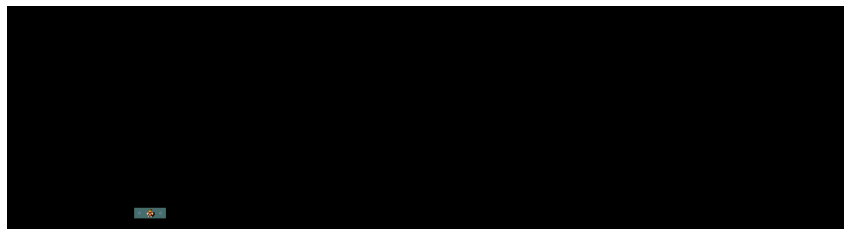

In [ ]:
# 6. Reset the environment and display the screen of the starting state
display_image(env.reset())

In [ ]:
# 7. Train the DQN Agent using diffrent seeds.
seeds = np.random.randint(100, size=1)
scores_array = []

for seed in seeds:
  print('=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~')
  print('seed:', seed)
  print('=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~')

  # Train the DQN Model
  scores = train_dqn_agent(env=env, seed=seed)

  # Store rewards for this iteration
  scores_array.append(scores)

  # Store rewards after each seed into binary file.
  np.save('/content/gdrive/MyDrive/RL PROJECT/dqn-quest_hard_scores', scores_array)

=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
seed: 47
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


episode reward: -0.7700000000000014
********************************************************
steps: 199
episodes: 1
mean 100 episode reward: nan
% time spent exploring: 0.9991045
********************************************************


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
% time spent exploring: 0.856
********************************************************
episode reward: -0.3400000000000005
********************************************************
steps: 32125
episodes: 139
mean 100 episode reward: -1.3
% time spent exploring: 0.8554375000000001
********************************************************
episode reward: -0.9000000000000009
********************************************************
steps: 32340
episodes: 140
mean 100 episode reward: -1.3
% time spent exploring: 0.85447
********************************************************
episode reward: -1.1400000000000012
********************************************************
steps: 32550
episodes: 141
mean 100 episode reward: -1.3
% time spent exploring: 0.853525
********************************************************
episode reward: -1.0900000000000014
********************************************************
steps: 32765
episodes: 142
mean 100 epis

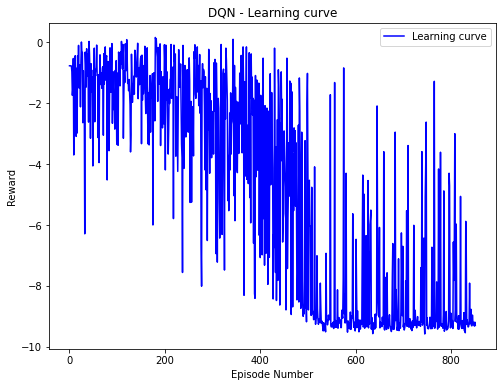

In [ ]:
# 1. load the scores and display the rewards over time.
quest_hard_scores = np.load("/content/gdrive/MyDrive/RL PROJECT/dqn-quest_hard_scores.npy", allow_pickle=True)
plot_results(scores=quest_hard_scores)

In [ ]:
# 2. initialize the environment
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"],
               reward_win=100, reward_lose=-1, actions=NAVIGATE_ACTIONS, reward_manager=reward_manager)

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  "A Box observation space has an unconventional shape (neither an image, nor a 1D vector). "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN:

In [ ]:
# 3. load the saved policy model to generate the video
model = DQN(env.action_space)
model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/RL PROJECT/dqn-checkpoint-{seeds[0]}.pth'))
model.eval()

DQN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=18, bias=True)
)

In [ ]:
# 4. initialise the state and images to create a gif
state = env.reset()
images = []
images.append(np.uint8(state['pixel']))
count = 0
cum_reward = 0

# continue until we terminate the game.
while True:
    # NB: No epxloration
    # initialize action to be random.
    action = env.action_space.sample()

    # standardize the state
    state = format_state(state)
    if not torch.cuda.is_available():
        state = state.type(torch.FloatTensor) 
    else:
        state = state.type(torch.cuda.FloatTensor)
    
    state = torch.unsqueeze(state, 0).to(device)

    # get the best action according to the trained policy network.
    result = model.forward(state)
    action = torch.argmax(result).item()
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    if done:
        break
    count += 1
    images.append(np.uint8(state['pixel']))
imageio.mimsave('/content/gdrive/MyDrive/RL PROJECT/dqn_agent.gif', images)
print('Number of Steps Taken:', count)
print('Total Reward:', cum_reward)

Number of Steps Taken: 999
Total Reward: -9.989999999999831


In [ ]:
## 5. Display the GIF
Image(filename='/content/gdrive/MyDrive/RL PROJECT/dqn_agent.gif')

Output hidden; open in https://colab.research.google.com to view.